In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from scipy.stats import norm

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt 
%matplotlib inline

import ast

import warnings
warnings.filterwarnings('ignore')

## Logistic Regression

__Load Dataset__

In [51]:
mov = pd.read_csv("may_5.csv")
mov_logit = mov[(mov["vote_count"] >= 20)]

cols = ['genres_clean_list', 'companies_clean_list', 'countries_clean_list', 'keywords_clean_list', 'cast_clean_list', 'crew_clean_list', 'cast_short_list', 'crew_short_list']
for i in range(len(mov)):
    for c in cols:
        mov[c].iloc[i] = ast.literal_eval(mov[c].iloc[i])

__sklearn Logistic Regression Models__

__Many-hot Encoding for Genres__

In [100]:
# many-hot encoding for genres

# get all unique genres
unique_cat = []
for i in range(len(mov_logit)):
    for name in mov_logit['genres_clean_list'].iloc[i]:
        if (name not in unique_cat):
            unique_cat.append(name)
            
# generate many-hot encoding for all movies
encoded_list = []
for i in range(len(mov_logit)):
    row = []
    for name in unique_cat:
        if (name in mov_logit['genres_clean_list'].iloc[i]):
            row.append(1)
        else:
            row.append(0)
    encoded_list.append(row)

mov_logit['genres_encoded'] = np.asarray(encoded_list)

__Setup for Models__

In [325]:
# converts vote average (rating) to 1s and 0s (meaning good and bad ratings)
def binary(y):
    vote_list = []
    for rating in y: 
        if rating >= 7.0:
            vote_list.append(1)
        else:
            vote_list.append(0)
    return vote_list

# Calculate p-values
def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p

# create feature space
X = np.concatenate((np.asarray(encoded_list), np.asarray(mov_logit["Budget in 2023"]).reshape(len(mov_logit), 1), np.asarray(mov_logit["runtime"]).reshape(len(mov_logit), 1), np.asarray(mov_logit["Year"]).reshape(len(mov_logit), 1)), axis = 1)

# train, test split
train_X, test_X, train_y, test_y = train_test_split(X, np.asarray(mov_logit["vote_average"]), test_size = 0.20, random_state = 100)

# set y to 1s and 0s
train_bi_y = binary(train_y)
test_bi_y = binary(test_y)

__Model with L2 Regularization__

Logistic Regression on IMDb Rating using L2 Regularization

Train Set Results

Intercept: -1.458621248903283e-07
Coefficients: [-5.05718517e-08 -4.22688215e-08 -3.30838082e-08 -2.44610843e-08
 -6.05966539e-09 -1.13459248e-08 -5.61274945e-08 -9.26531219e-08
 -1.47595266e-08 -7.12618039e-09 -1.60912792e-08  1.15574073e-08
 -1.32206544e-08 -2.27871733e-09 -4.60936609e-09  5.41829169e-09
  6.00032214e-09 -5.64884995e-10 -2.36008927e-10 -2.64323020e-10
 -2.55954916e-09 -1.09320346e-05 -2.93932983e-04]
Accuracy score: 0.8045938748335553


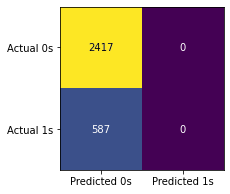

Test Set Results

Accuracy score: 0.7922769640479361


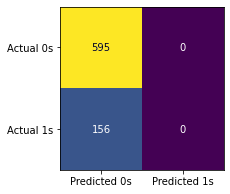

p-values
 [0.99999998 0.99999968 0.99999975 0.9999998  0.99999988 0.99999997
 0.99999995 0.99999972 0.99999939 0.99999991 0.99999997 0.99999989
 0.99999997 0.99999995 0.99999999 0.99999999 0.99999998 0.99999999
 1.         1.         1.         0.0564474  0.9973459  0.92580374]


In [326]:
# RESULTS OF MODEL
print('Logistic Regression on IMDb Rating using L2 Regularization\n')
logreg = LogisticRegression(random_state = 0, multi_class = 'multinomial', solver='lbfgs') #C = 1e30
model = logreg.fit(train_X, train_bi_y)

# print results: coefficient, accuracy score, confusion matrix
print('Train Set Results\n')

print('Intercept:', model.intercept_[0])
print('Coefficients:', model.coef_[0])
#for i in range(len(x_list)):
    #print('-', x_list[i], ':', model.coef_[0][i])
print('Accuracy score:', model.score(train_X, np.asarray(train_bi_y).reshape(-1, 1)))

# confusion matrix
cm = confusion_matrix(train_bi_y, model.predict(train_X))

fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
ax.text(0, 0, cm[0, 0], ha='center', va='center', color='black')
plt.show()

#print(classification_report(train_bi_y, model.predict(train_X)))
print('Test Set Results\n')

# print test results
#print('Intercept:', model.intercept_[0])
#print('Coefficients:', model.coef_[0]) 
#for i in range(len(x_list)):
    #print('-', x_list[i], ':', model.coef_[0][i])
print('Accuracy score:', model.score(test_X, np.asarray(test_bi_y).reshape(-1, 1)))

# confusion matrix
cm = confusion_matrix(test_bi_y, model.predict(test_X))

fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
ax.text(0, 0, cm[0, 0], ha='center', va='center', color='black')
plt.show()

#print(classification_report(test_bi_y, model.predict(test_X)))


# print p-values
print('p-values\n', logit_pvalue(model, train_X))

__Model with L1 Regularization__

Logistic Regression on IMDb Rating using L1 Regularization

Train Set Results

Intercept: -4.762257989180302e-13
Coefficients: [-1.63334056e-13 -1.37027923e-13 -1.05821804e-13 -7.85286061e-14
 -1.83191287e-14 -3.54574414e-14 -1.82110428e-13 -3.00751983e-13
 -4.60265051e-14 -2.15168047e-14 -4.99944742e-14  3.59579125e-14
 -4.15501067e-14 -5.65427799e-15 -1.32200915e-14  1.58418160e-14
  1.77225516e-14 -1.20937974e-16  0.00000000e+00  0.00000000e+00
 -1.11793835e-08 -3.56715950e-11 -9.59663789e-10]
Accuracy score: 0.8045938748335553


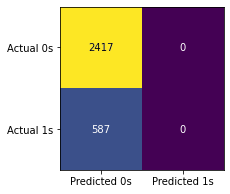

Test Set Results

Accuracy score: 0.7922769640479361


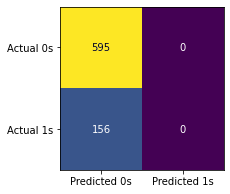

p-values
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 7.22542026e-11 9.99999991e-01 9.99999727e-01]


In [327]:
# RESULTS OF MODEL
print('Logistic Regression on IMDb Rating using L1 Regularization\n')
logreg = LogisticRegression(random_state = 0, multi_class = 'multinomial', solver='saga', penalty = 'l1') #C = 1e30,
model = logreg.fit(train_X, train_bi_y)

# print results: coefficient, accuracy score, confusion matrix
print('Train Set Results\n')

print('Intercept:', model.intercept_[0])
print('Coefficients:', model.coef_[0])
#for i in range(len(x_list)):
    #print('-', x_list[i], ':', model.coef_[0][i])
print('Accuracy score:', model.score(train_X, np.asarray(train_bi_y).reshape(-1, 1)))

# confusion matrix
cm = confusion_matrix(train_bi_y, model.predict(train_X))

fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
ax.text(0, 0, cm[0, 0], ha='center', va='center', color='black')
plt.show()

#print(classification_report(train_bi_y, model.predict(train_X)))
print('Test Set Results\n')

# print test results
#print('Intercept:', model.intercept_[0])
#print('Coefficients:', model.coef_[0]) 
#for i in range(len(x_list)):
    #print('-', x_list[i], ':', model.coef_[0][i])
print('Accuracy score:', model.score(test_X, np.asarray(test_bi_y).reshape(-1, 1)))

# confusion matrix
cm = confusion_matrix(test_bi_y, model.predict(test_X))

fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
ax.text(0, 0, cm[0, 0], ha='center', va='center', color='black')
plt.show()

#print(classification_report(test_bi_y, model.predict(test_X)))


# print p-values
print('p-values\n', logit_pvalue(model, train_X))